In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import src.text_analysis as ta
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

In [6]:
df = pd.read_csv('input/amazon_reviews.csv')

In [7]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
df.columns = df.columns.str.lower()

In [9]:
df = df[["productid", "userid", "score", "text"]]

In [10]:
df.isna().sum()

productid    0
userid       0
score        0
text         0
dtype: int64

In [11]:
df.head()

,productid,userid,score,text
0,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...


In [12]:
df.shape

(568454, 4)

In [13]:
df.duplicated().sum()

1289

In [14]:
df = df.drop_duplicates()

In [15]:
df = df.reset_index(drop=True)

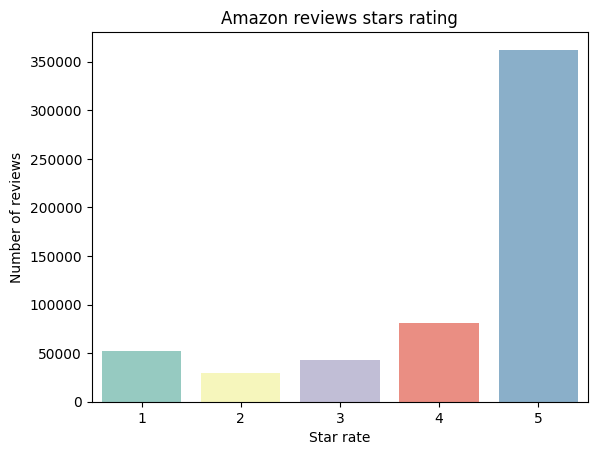

In [16]:
ax = sns.countplot(x="score",data=df, palette="Set3")
ax.set(xlabel='Star rate', ylabel='Number of reviews')
plt.title('Amazon reviews stars rating')
plt.show()

In [17]:
df_reviews_per_user = df.groupby(['userid'])["score"].count().to_frame().reset_index().rename(columns={"score":"total_reviews"}).sort_values(by="total_reviews", ascending=False)

In [18]:
df_reviews_per_user.head(5)

,userid,total_reviews
182011,A3OXHLG6DIBRW8,442
65586,A1YUL9PCJR3JTY,410
252275,AY12DBB0U420B,389
82919,A281NPSIMI1C2R,365
66162,A1Z54EM24Y40LL,256


In [19]:
df_reviews_per_user.total_reviews.describe()

count    256059.000000
mean          2.214978
std           4.374043
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         442.000000
Name: total_reviews, dtype: float64

75% of all the customers in the data set left less than 2 reviews

In [20]:
df_reviews_per_product = df.groupby(['productid'])["score"].count().to_frame().reset_index().rename(columns={"score":"total_reviews"}).sort_values(by="total_reviews", ascending=False)

In [21]:
df_reviews_per_product.head(5)

,productid,total_reviews
71170,B007JFMH8M,913
42264,B002QWP8H0,630
37898,B0026RQTGE,630
42263,B002QWP89S,630
42257,B002QWHJOU,630


In [22]:
df_reviews_per_product.total_reviews.describe()

count    74258.000000
mean         7.637763
std         26.369823
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        913.000000
Name: total_reviews, dtype: float64

75% of all the products in the data set have less than 5 reviews

### Labeling the reviews
https://news.cornell.edu/stories/2011/07/cornell-computers-spot-opinion-spam-online-reviews

### Polarity and subjectivity analysis


In [23]:
polarity,subjectivity = ta.sentimental(df.text)
df['polarity'] = polarity
df['subjectivity'] = subjectivity

### Readability analysis and words counting

In [24]:
lexicon_count, flesch_reading = ta.textscore(df.text)
df['num_words'] = lexicon_count
df['flesch_score'] = flesch_reading

### Verbs, nouns and prp ratios


In [25]:
tags = ['verbs','nouns','prp']
for tag in tags: 
    df[f'{tag}_ratio'] = (ta.tags_collector (tag, df.text)/df.num_words).round(decimals=2)

In [26]:
columns_names = list(df.columns)
columns_names.remove("productid")
columns_names.remove("userid")
columns_names.remove("text")

In [27]:
scores = {}
for idx in columns_names:
    print(f'The average {idx} is {df[idx].mean()}')
    scores[idx] = df[idx].mean()

The average score is 4.184038154681618
The average polarity is 0.2417408161646082
The average subjectivity is 0.549362901448432
The average num_words is 79.5089577107191
The average flesch_score is 81.23819893681734
The average verbs_ratio is 0.144711168707519
The average nouns_ratio is 0.27448072430421466
The average prp_ratio is 0.0921546287235637


In [28]:
for idx in columns_names:
    df[f'{idx}_class'] = df[idx].apply(lambda x: True if x > scores[idx] else False)

In [29]:
df.shape

(567165, 19)

In [30]:
df_hq = (df[(df["flesch_score_class"]== True) &
    (df["verbs_ratio_class"] == False) &
    (df["nouns_ratio_class"] == True) &
    (df["prp_ratio_class"] == True)
   ])

In [31]:
df_lq = (df[(df["flesch_score_class"]== False) &
    (df["verbs_ratio_class"] == True) &
    (df["nouns_ratio_class"] == False) &
    (df["prp_ratio_class"] == False)
   ])

In [32]:
df_hq.shape

(14842, 19)

In [33]:
df_lq.shape

(35788, 19)

In [34]:
df_hq["quality"] = "hq"
df_lq["quality"] = "lq"
df_class = pd.concat([df_hq, df_lq], ignore_index=True)
df_class = df_class[["text", "quality"]]
df_class.head()

,text,quality
0,"The candy is just red , No flavor . Just plan...",hq
1,"The flavors are good. However, I do not see a...",hq
2,No tea flavor at all. Just whole brunch of art...,hq
3,I've been a fan of Hot & Spicy Maruchan Ramen ...,hq
4,This is a fabulous marinade! I love to use it...,hq


In [35]:
df_class.shape

(50630, 2)

In [ ]:
df_class.to_csv("output/df_class.csv", index=False)

In [36]:
df_class.quality.value_counts(normalize=True)

lq    0.706854
hq    0.293146
Name: quality, dtype: float64

In [69]:
tfidf = TfidfVectorizer(tokenizer=ta.nltk_tokenizer)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_class['text'], df_class['quality'], test_size=0.25, random_state=28, shuffle=True)

In [71]:
train = tfidf.fit_transform(X_train.values.astype('U'))

### Training several models at once


In [73]:
train = tfidf.fit_transform(X_train.values.astype('U'))
test = tfidf.transform(X_test.values.astype('U'))

In [42]:
models = {
    "PassiveAggressiveClassifier" : PassiveAggressiveClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "AdaBoostClassifier" : AdaBoostClassifier(),
    "RandomForestClassifier" : RandomForestClassifier(),
    "SVC" : SVC()
}

In [43]:
for name, model in models.items():
    print(f"Training {name}")
    model.fit(train, y_train)
print("All the models have been trained")

Training PassiveAggressiveClassifier
Training GradientBoostingClassifier
Training AdaBoostClassifier
Training RandomForestClassifier
Training SVC
All the models have been trained


In [44]:
for name, model in models.items():
    y_pred = model.predict(test)
    print(f"-------{name}-------")
    print (f"Accuracy: {accuracy_score(y_test,y_pred)*100:.3}%")
    print(f"Precission: {precision_score(y_test,y_pred, average = 'weighted')*100:.3}%")
    print(f"Recall: {recall_score(y_test,y_pred, average = 'weighted')*100:.3}%")
    print(f"F1_score: {f1_score(y_test,y_pred, average = 'weighted')*100:.3}%")

-------PassiveAggressiveClassifier-------
Accuracy: 98.4%
Precission: 98.4%
Recall: 98.4%
F1_score: 98.4%
-------GradientBoostingClassifier-------
Accuracy: 91.9%
Precission: 92.0%
Recall: 91.9%
F1_score: 91.7%
-------AdaBoostClassifier-------
Accuracy: 92.2%
Precission: 92.1%
Recall: 92.2%
F1_score: 92.1%
-------RandomForestClassifier-------
Accuracy: 92.9%
Precission: 93.2%
Recall: 92.9%
F1_score: 92.6%
-------SVC-------
Accuracy: 98.4%
Precission: 98.4%
Recall: 98.4%
F1_score: 98.4%


In [46]:
confusion_matrix(y_test,y_pred, labels = ['hq','lq'])

array([[3587,  134],
       [  64, 8873]])

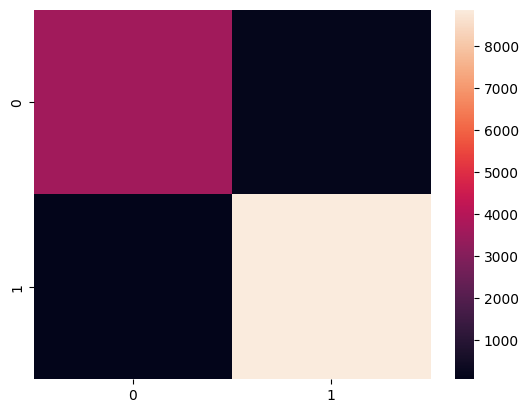

In [49]:
sns.heatmap(confusion_matrix(y_test,y_pred, labels = ['hq','lq']))
plt.show()


### K-fold cross validation


In [91]:
X = tfidf.fit_transform(df_class['text'].values.astype('U'))

In [54]:
for name, model in models.items():
    print(f"{name}")
    validation = cross_val_score(model, X, df_class['quality'].values, cv=5)
    print(f'K-fold cross validation Accuracy: {round(validation.mean() * 100,2)}%')

PassiveAggressiveClassifier
K-fold cross validation Accuracy: 98.48%
GradientBoostingClassifier
K-fold cross validation Accuracy: 92.01%
AdaBoostClassifier
K-fold cross validation Accuracy: 92.37%
RandomForestClassifier
K-fold cross validation Accuracy: 92.49%
SVC
K-fold cross validation Accuracy: 98.49%


After applying a k-fold cross validation I decided to select Support Vector Classification (SVC).

In [59]:
model = SVC()
model.fit(X, df_class['quality'].values)

SVC()

In [93]:
model.predict(tfidf.transform(["clearly a fake review"]))[0]

'lq'

In [113]:
model.predict(tfidf.transform(["The pop arrived on time, I really like how it looks on my shelf, will order it again as a present"]))[0]

'hq'